In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
file_names = {
    "train": "/content/drive/MyDrive/MA5811-1 - Primavera 2021: Felipe Urrutia/train_task_C1.xlsx",
    "test": "/content/drive/MyDrive/MA5811-1 - Primavera 2021: Felipe Urrutia/test_task_C1.xlsx",
    "val": "/content/drive/MyDrive/MA5811-1 - Primavera 2021: Felipe Urrutia/val_task_C1.xlsx",
}

In [3]:
A_train = pd.read_excel(file_names["train"], index_col="id").sample(frac = 1, random_state=2022).reset_index()
A_val = pd.read_excel(file_names["val"])
A_test = pd.read_excel(file_names["test"])

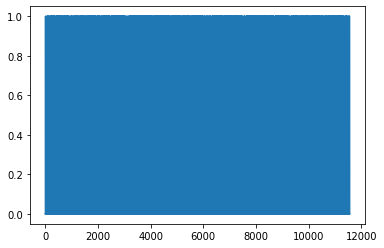

In [ ]:
A_train["label"].plot()

In [4]:
%%capture
!pip install transformers
!pip install datasets
!pip install torch

In [5]:
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
model_name = "dccuchile/bert-base-spanish-wwm-cased"
beto_model = BertModel.from_pretrained(model_name)
beto_tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
e = beto_model.eval()

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bi

In [ ]:
beto_tokenizer.all_special_tokens, beto_tokenizer.all_special_ids

(['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'], [3, 5, 1, 4, 0])

In [ ]:
from torch.utils.data import Dataset
class DatasetTaskC1(Dataset):
    def __init__(self, df, maxlen):
        self.df = df
        self.tokenizer = beto_tokenizer
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sentence1 = str(self.df.loc[index, 'Q'])
        sentence2 = str(self.df.loc[index, 'A'])
        
        sentence1 = " ".join(str(sentence1).replace("\n", " ").split())
        sentence2 = " ".join(str(sentence2).replace("\n", " ").split())

        label = self.df.loc[index, 'label']
        
        tokens1 = self.tokenizer.tokenize(sentence1) if len(sentence1)>0 else ["[UNK]"]
        tokens2 = self.tokenizer.tokenize(sentence2) if len(sentence2)>0 else ["[UNK]"]

        if len(tokens1) < self.maxlen:
            tokens1 = tokens1 + ['[PAD]' for _ in range(self.maxlen - len(tokens1))]
        else:
            tokens1 = tokens1[:self.maxlen]

        if len(tokens2) < self.maxlen:
            tokens2 = tokens2 + ['[PAD]' for _ in range(self.maxlen - len(tokens2))]
        else:
            tokens2 = tokens2[:self.maxlen]
          
        tokens = ["[CLS]"]+tokens1+["[SEP]"]+tokens2+["[SEP]"]
        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids_tensor = torch.tensor(tokens_ids)
        attn_mask = (tokens_ids_tensor != 1).long() # [PAD] => 1

        return tokens_ids_tensor, attn_mask, label

In [ ]:
from torch.utils.data import DataLoader

train_set = DatasetTaskC1(df = A_train, maxlen = 60)
val_set = DatasetTaskC1(df = A_val, maxlen = 60)

train_loader = DataLoader(train_set, batch_size = 64, num_workers = 2, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 64, num_workers = 2, shuffle=False)

In [ ]:
import torch.nn as nn
class C1Classifier(nn.Module):
    def __init__(self):
        super(C1Classifier, self).__init__()
        torch.manual_seed(2022)
        
        self.bert_layer = BertModel.from_pretrained(model_name).cuda()
        self.cls_layer = nn.Linear(768, 2).cuda()

    def forward(self, seq, attn_masks):

        cont_reps = self.bert_layer(seq, attention_mask=attn_masks)
        cls_rep = cont_reps.last_hidden_state[:, 0]
        logits = self.cls_layer(cls_rep)

        return logits

In [ ]:
import torch.optim as optim

net = C1Classifier()

weights = torch.tensor([1., 6.5])
criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean').cuda()

opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bi

Parameter containing:
tensor([[-0.0015,  0.0125, -0.0236,  ..., -0.0159,  0.0076,  0.0264],
        [ 0.0159, -0.0342,  0.0237,  ..., -0.0026,  0.0161, -0.0150]],
       device='cuda:0', requires_grad=True)

In [ ]:
def get_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits)
    soft_probs = probs.argmax(1)
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc
    
def evaluate(net, criterion, dataloader):
    net.eval()
    mean_acc, mean_loss = 0, 0
    count = 0
    with torch.no_grad():
        for seq, attn_masks, labels in dataloader:
            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(seq, attn_masks)
            mean_loss += criterion(logits, labels).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def evaluate_precision_recall_fscore_support(net, dataloader):
    net.eval()
    preds = []
    tests = []
    with torch.no_grad():
        for seq, attn_masks, labels in dataloader:
            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(seq, attn_masks)
            probs = torch.sigmoid(logits)
            soft_probs = probs.argmax(1)
            preds += soft_probs.squeeze().tolist()
            tests += labels.tolist()
    return tests, preds

In [ ]:
def train(net, criterion, opti, train_loader, val_loader, epochs):
    for ep in range(epochs):
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            opti.zero_grad()  

            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()

            logits = net(seq, attn_masks)

            loss = criterion(logits, labels)

            loss.backward()

            opti.step()

            if (it + 1) % 100 == 0:
                acc = get_accuracy_from_logits(logits, labels)
                # tests, preds = evaluate_precision_recall_fscore_support(net, train_loader)
                # print(classification_report(tests, preds))
                print("Iteration {} of epoch {} complete. Loss : {} Train Accuracy : {}".format(it+1, ep+1, loss.item(), acc))
        val_acc, val_loss = evaluate(net, criterion, val_loader)
        tests, preds = evaluate_precision_recall_fscore_support(net, val_loader)
        print(classification_report(tests, preds))
        print("Epoch {} complete! Validation Accuracy : {}, Validation Loss : {}".format(ep+1, val_acc, val_loss))

In [ ]:
epochs = 4
train(net, criterion, opti, train_loader, val_loader, epochs)

Iteration 100 of epoch 1 complete. Loss : 0.27556920051574707 Train Accuracy : 0.90625
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      2510
           1       0.55      0.94      0.70       388

    accuracy                           0.89      2898
   macro avg       0.77      0.91      0.82      2898
weighted avg       0.93      0.89      0.90      2898

Epoch 1 complete! Validation Accuracy : 0.8926630616188049, Validation Loss : 0.2268175551586825
Iteration 100 of epoch 2 complete. Loss : 0.06490065902471542 Train Accuracy : 0.9375
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2510
           1       0.57      0.93      0.71       388

    accuracy                           0.90      2898
   macro avg       0.78      0.91      0.82      2898
weighted avg       0.93      0.90      0.91      2898

Epoch 2 complete! Validation Accuracy : 0.8979091048240662, Validation Loss 

In [6]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
!git config --global credential.helper store

In [ ]:
repo_name = "beto_ft_task_C1"
net.bert_layer.push_to_hub(repo_name)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='beto_ft_task_C1' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/furrutiav/beto_ft_task_C1 into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/419M [00:00<?, ?B/s]

To https://huggingface.co/furrutiav/beto_ft_task_C1
   2dd5b92..b29a1a7  main -> main

   2dd5b92..b29a1a7  main -> main



'https://huggingface.co/furrutiav/beto_ft_task_C1/commit/b29a1a7632537fa8c20ed0b1092ea4de700082bd'

In [ ]:
val_set.tokenizer.push_to_hub(repo_name)

To https://huggingface.co/furrutiav/beto_ft_task_C1
   b29a1a7..d778ac7  main -> main

   b29a1a7..d778ac7  main -> main



'https://huggingface.co/furrutiav/beto_ft_task_C1/commit/d778ac78e9ad3f10af9e7de2440b743a630a878c'

In [ ]:
torch.save(net.cls_layer, "cls_layer.torch")

In [7]:
from huggingface_hub import hf_hub_url, cached_download

In [11]:
repo_name = "beto_ft_task_C1"
config_file_url = hf_hub_url("furrutiav/"+repo_name, filename="cls_layer.torch")
value = cached_download(config_file_url)
cls_layer = torch.load(value)

In [20]:
beto_model = BertModel.from_pretrained("furrutiav/"+repo_name).cuda()
beto_tokenizer = BertTokenizer.from_pretrained("furrutiav/"+repo_name, do_lower_case=False)
e = beto_model.eval()

In [21]:
 def preproccesing(Q, A, maxlen=60):
        sentence1 = str(Q)
        sentence2 = str(A)
        
        sentence1 = " ".join(str(sentence1).replace("\n", " ").split())
        sentence2 = " ".join(str(sentence2).replace("\n", " ").split())
        
        tokens1 = beto_tokenizer.tokenize(sentence1) if len(sentence1)>0 else ["[UNK]"]
        tokens2 = beto_tokenizer.tokenize(sentence2) if len(sentence2)>0 else ["[UNK]"]

        if len(tokens1) < maxlen:
            tokens1 = tokens1 + ['[PAD]' for _ in range(maxlen - len(tokens1))]
        else:
            tokens1 = tokens1[:maxlen]

        if len(tokens2) < maxlen:
            tokens2 = tokens2 + ['[PAD]' for _ in range(maxlen - len(tokens2))]
        else:
            tokens2 = tokens2[:maxlen]
          
        tokens = ["[CLS]"]+tokens1+["[SEP]"]+tokens2+["[SEP]"]
        tokens_ids = beto_tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids_tensor = torch.tensor(tokens_ids)
        attn_mask = (tokens_ids_tensor != 1).long() # [PAD] => 1

        return tokens_ids_tensor.cuda(), attn_mask.cuda()

In [24]:
def C1Classifier(Q, A):
    tokens_ids_tensor, attn_mask = preproccesing(Q, A)
    cont_reps = beto_model(tokens_ids_tensor.unsqueeze(0), attention_mask = attn_mask.unsqueeze(0))
    cls_rep = cont_reps.last_hidden_state[:, 0]
    logits = cls_layer(cls_rep)
    probs = torch.sigmoid(logits)
    return probs.detach().cpu().numpy()[0]

In [30]:
Q = "Julieta tiene 20 láminas y le regaló 12 a Daniela ¿Cuántas láminas tiene ahora Julieta? Explica con tus palabras."
A1 = "1 porque si"
C1Classifier(Q, A1)

array([0.9007121 , 0.09371062], dtype=float32)

In [37]:
from sklearn.metrics import classification_report

In [42]:
%%time
y_pred = A_train.apply(lambda x: int(C1Classifier(x["Q"], x["A"])[0]<0.5), axis=1)
report = classification_report(A_train["label"], y_pred, output_dict=True)
train_report = pd.DataFrame(report)
train_report

CPU times: user 2min 53s, sys: 413 ms, total: 2min 53s
Wall time: 2min 58s


,0,1,accuracy,macro avg,weighted avg
precision,0.999900,0.982131,0.997491,0.991016,0.997533
recall,0.997205,0.999351,0.997491,0.998278,0.997491
f1-score,0.998551,0.990666,0.997491,0.994609,0.997500
support,10019.000000,1540.000000,0.997491,11559.000000,11559.000000


In [43]:
%%time
y_pred = A_val.apply(lambda x: int(C1Classifier(x["Q"], x["A"])[0]<0.5), axis=1)
report = classification_report(A_val["label"], y_pred, output_dict=True)
val_report = pd.DataFrame(report)
val_report

CPU times: user 41.4 s, sys: 96.1 ms, total: 41.4 s
Wall time: 41.8 s


,0,1,accuracy,macro avg,weighted avg
precision,0.976334,0.812346,0.953416,0.894340,0.954378
recall,0.969721,0.847938,0.953416,0.908830,0.953416
f1-score,0.973016,0.829760,0.953416,0.901388,0.953836
support,2510.000000,388.000000,0.953416,2898.000000,2898.000000


In [44]:
%%time
y_pred = A_test.apply(lambda x: int(C1Classifier(x["Q"], x["A"])[0]<0.5), axis=1)
report = classification_report(A_test["label"], y_pred, output_dict=True)
test_report = pd.DataFrame(report)
test_report

CPU times: user 9.25 s, sys: 22.7 ms, total: 9.27 s
Wall time: 9.28 s


,0,1,accuracy,macro avg,weighted avg
precision,0.945693,0.748252,0.903988,0.846972,0.906030
recall,0.933457,0.786765,0.903988,0.860111,0.903988
f1-score,0.939535,0.767025,0.903988,0.853280,0.904880
support,541.000000,136.000000,0.903988,677.000000,677.000000


In [47]:
best_params = {
    "batch": 64, 
    "criterion": "CrossEntropy", 
    "epochs": 4, 
    "learning_rate": 2e-5, 
    "weights": "balanced 1/6.5",
    "max_len": 60, 
}

In [48]:
pickle.dump(best_params, open("best_params_beto_ft_task_C1.pickle", "wb"))

In [49]:
pickle.dump(train_report, open("train_report_beto_ft_task_C1.pickle", "wb"))

In [50]:
pickle.dump(val_report, open("val_report_beto_ft_task_C1.pickle", "wb"))

In [51]:
pickle.dump(test_report, open("test_report_beto_ft_task_C1.pickle", "wb"))